In [2]:
import os
import pandas as pd
import numpy as np
import random

#import graphviz
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
## Download Data from OpenML https://www.openml.org/d/37
df_diabetes = pd.read_csv('pima_diabetes.csv')

In [5]:
df_diabetes.shape

(768, 9)

In [6]:
#df_diabetes.head(5)

In [7]:
print (df_diabetes.isnull().values.any())

False


In [8]:
#Encoding categorical data values
#from sklearn.preprocessing import LabelEncoder
#labelencoder_Y = LabelEncoder()
#Y = labelencoder_Y.fit_transform(Y)

In [9]:
diabetes_map = {'tested_positive' : 1, 'tested_negative' : 0}
df_diabetes['class'] = df_diabetes['class'].map(diabetes_map)

In [10]:
#df_diabetes.head(5)

In [11]:
percent = df_diabetes['class'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
percent

0    65.1%
1    34.9%
Name: class, dtype: object

In [12]:
import sklearn.tree as tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


# Data structures for storing best accuracies, training time and test time
classifiers = 6
class_accuracy = np.zeros(classifiers)
train_time = np.zeros(classifiers)
test_time = np.zeros(classifiers)

prev_class_accuracy = np.zeros(classifiers)
prev_train_time = np.zeros(classifiers)
prev_test_time = np.zeros(classifiers)

# Helper Functions

In [13]:
from sklearn.model_selection import validation_curve, learning_curve, cross_validate, train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import time
import math

def import_data():
    X1 = np.array(df_diabetes.iloc[:,:-1].values)
    Y1 = np.array(df_diabetes.iloc[:,-1].values)
    #X1 = np.array(df_cancer.iloc[:,:-1].values,dtype='int64')
    #Y1 = np.array(df_cancer.iloc[:,-1].values,dtype='int64')
    return X1, Y1

def plot_validation_curve(estimator,X, y, param_name, param_range,cv_value,scoring,no_jobs,title,xlabel, ylim = None):
    #param_range = np.logspace(-6, -1, 5)
    train_scores, test_scores = validation_curve(estimator,
    X, y, param_name=param_name, param_range=param_range,
    cv=cv_value, scoring=scoring, n_jobs=no_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Classification Score")
    if ylim is not None:
        plt.ylim(*ylim)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()
    #return plt


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Claassification Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



# Load Data

In [176]:
diaX,diaY = import_data()
diaX_train, diaX_test, diay_train, diay_test = train_test_split(np.array(diaX),np.array(diaY), test_size=0.20)
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(diaX_train, diay_train)
print(clf.score(diaX_test, diay_test))


0.6688311688311688


# Decision Tree

Model Evaluation Metrics Using Decision Tree before pruning (Diabetets)
**********************************************************************
Model Training Time (s):   0.00299
Model Prediction Time (s): 0.00097
Accuracy:  0.69


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

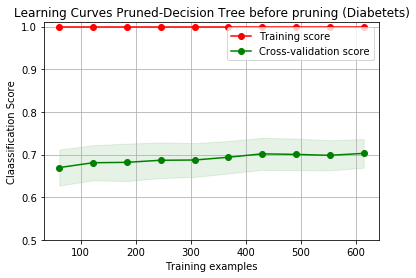

In [177]:
# Create Decision Tree classifer object
dt_clf1 = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_features=None, random_state=10, 
                                 max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                 class_weight=None, presort=False)

# Train Decision Tree Classifer
t0 = time.time()
dt_clf1 = dt_clf1.fit(diaX_train,diay_train)
t1 = time.time()
prev_train_time[0] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = dt_clf1.predict(diaX_test)
t1 = time.time()
prev_test_time[0] = t1 - t0

# Model Accuracy, how often is the classifier correct?
prev_class_accuracy[0] = accuracy_score(diay_test, diay_pred)

print("Model Evaluation Metrics Using Decision Tree before pruning (Diabetets)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(prev_train_time[0]))
print("Model Prediction Time (s): "+"{:.5f}".format(prev_test_time[0]))
print("Accuracy:  "+"{:.2f}".format(prev_class_accuracy[0]))

#learning curve plot
title = "Learning Curves Pruned-Decision Tree before pruning (Diabetets)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(dt_clf1, title, diaX, diaY, ylim=(0.5, 1.01), cv=cv, n_jobs=4)


## Validation Curve

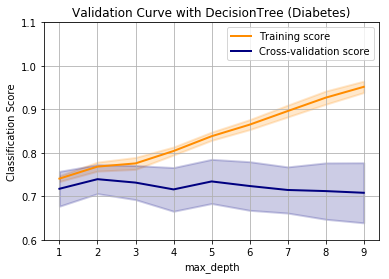

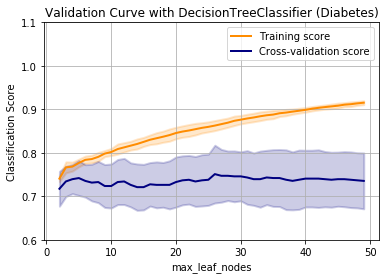

In [69]:
#plot validation curve
estimator = dt_clf1
parameter_range1 = np.arange(1, 10)
#parameter_range1 = np.arange(1, 50)
param_name1 = "max_depth"

#parameter_range2 = np.arange(math.ceil(0.01* len(diaX_train)), math.ceil(0.3 * len(diaX_train)),5)
parameter_range2 = np.arange(2,50)
#parameter_range2 = np.arange(2,200)
param_name2 = "max_leaf_nodes"
#param_name2 = "min_samples_leaf"

plot_validation_curve(estimator, diaX, diaY, param_name1, parameter_range1, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve with DecisionTree (Diabetes)", xlabel=param_name1, ylim= (0.6, 1.1))


plot_validation_curve(estimator, diaX, diaY, param_name2, parameter_range2, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve with DecisionTreeClassifier (Diabetes)", xlabel=param_name2, ylim= (0.6, 1.1))


## Best Param Search

From the validation curve, max_depth is between 1 to 3 and max_leaf_nodes is between 2 to 6. So using Grid search to find best parameters.

In [178]:
# use a full grid over all parameters
'''(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_features=None, random_state=10, 
                                 max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
                                 class_weight=None, presort=False)'''
param_tuned = {"max_features": [3, 5, 7, None],
               "max_depth": range(2,5),
               #"min_samples_leaf": range(math.ceil(0.03* len(diaX_train)), math.ceil(1 * len(diaX_train)),10),
               "min_samples_leaf": range(1,math.ceil(0.05* len(diaX_train)),5),
               "max_leaf_nodes": range(2,10),
               "min_samples_split": range(2, 20, 2),
               "splitter": ["best", "random"]}

# run grid search
grid_search = GridSearchCV(dt_clf1, param_grid=param_tuned, cv=5, iid=False, n_jobs = 4)
grid_search.fit(diaX_train,diay_train)
print("Best parameters for development set:")
print(grid_search.best_params_)

Best parameters for development set:
{'max_depth': 4, 'max_features': 5, 'max_leaf_nodes': 8, 'min_samples_leaf': 16, 'min_samples_split': 2, 'splitter': 'best'}


## After Tunning

Model Evaluation Metrics Using Decision Tree after tuning (Diabetets)
**********************************************************************
Model Training Time (s):   0.00100
Model Prediction Time (s): 0.00099
Accuracy:  0.75


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

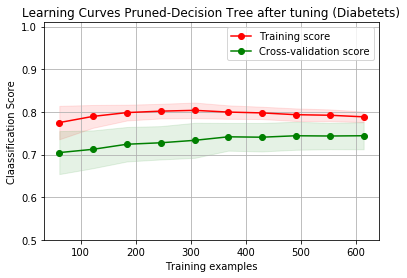

In [180]:
# Create Decision Tree classifer object

'''dt_clf1_pruned6= DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=3, min_samples_split=2, 
                             min_samples_leaf=6, min_weight_fraction_leaf=0.0, max_features=None, 
                             random_state=10, max_leaf_nodes=8, min_impurity_decrease=0.0, 
                             min_impurity_split=None, class_weight=None, presort=False)'''
 
dt_clf2= DecisionTreeClassifier(criterion='gini', max_depth=4, max_features=5, max_leaf_nodes=8, min_samples_leaf=16,
                                min_samples_split=2, splitter='best', min_weight_fraction_leaf=0.0, 
                                random_state=10,  min_impurity_decrease=0.0, min_impurity_split=None, 
                                class_weight=None, presort=False)

# Train Decision Tree Classifer
t0 = time.time()
ddt_clf2= dt_clf2.fit(diaX_train,diay_train)
t1 = time.time()
train_time[0] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = dt_clf2.predict(diaX_test)
t1 = time.time()
test_time[0] = t1 - t0

# Model Accuracy, how often is the classifier correct?
class_accuracy[0] = accuracy_score(diay_test, diay_pred)
f1 = f1_score(diay_test, diay_pred)
precision = precision_score(diay_test, diay_pred)
recall = recall_score(diay_test, diay_pred)
cm = confusion_matrix(diay_test, diay_pred)

print("Model Evaluation Metrics Using Decision Tree after tuning (Diabetets)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(train_time[0]))
print("Model Prediction Time (s): "+"{:.5f}".format(test_time[0]))
print("Accuracy:  "+"{:.2f}".format(class_accuracy[0]))

#learning curve plot
title = "Learning Curves Pruned-Decision Tree after tuning (Diabetets)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(dt_clf2, title, diaX, diaY, ylim=(0.5, 1.01), cv=cv, n_jobs=4)

# Neural Networks

Model Evaluation Metrics for Neural Networks before tuning (Diabetes)
**********************************************************************
Model Training Time (s):   0.16256
Model Prediction Time (s): 0.00000
Accuracy:  0.69


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

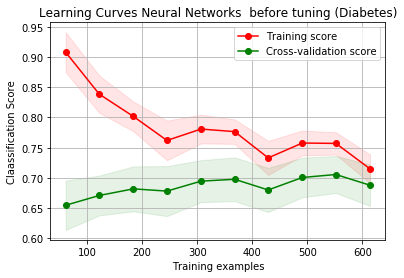

In [35]:
nn_clf1 = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001, 
                        batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, 
                        max_iter=200, shuffle=True, random_state=20, tol=0.0001, verbose=False, warm_start=False, 
                        momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)

# Train Decision Tree Classifer
t0 = time.time()
nn_clf1 = nn_clf1.fit(diaX_train,diay_train)
t1 = time.time()
prev_train_time[1] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = nn_clf1.predict(diaX_test)
t1 = time.time()
prev_test_time[1] = t1 - t0

# Model Accuracy, how often is the classifier correct?
prev_class_accuracy[1] = accuracy_score(diay_test, diay_pred)

print("Model Evaluation Metrics for Neural Networks before tuning (Diabetes)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(prev_train_time[1]))
print("Model Prediction Time (s): "+"{:.5f}".format(prev_test_time[1]))
print("Accuracy:  "+"{:.2f}".format(prev_class_accuracy[1]))

#learning curve plot
title = "Learning Curves Neural Networks  before tuning (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(nn_clf1, title, diaX, diaY, ylim=None, cv=cv, n_jobs=4)

## Validation Curve

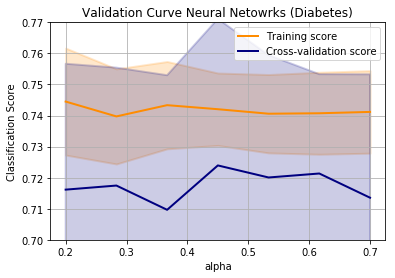

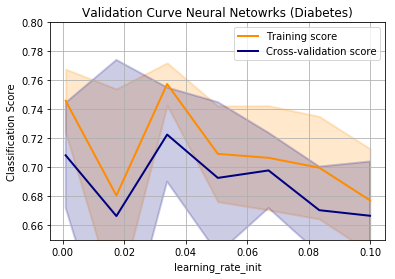

In [17]:
#plot validation curve
estimator = nn_clf1
#parameter_range1 = np.logspace(-3, 3, 7)
#parameter_range1 = np.linspace(0.0001, 0.01, 7)
#parameter_range1 = np.linspace(0.4, 0.65, 7)
parameter_range1 = np.linspace(0.2, 0.7, 7)
param_name1 = "alpha"

#parameter_range2 = np.logspace(-5, 1, 6)
#parameter_range2 = np.linspace(0.001, 0.9, 7)
#parameter_range2 = np.linspace(0.02, 0.45, 7)
parameter_range2 = np.linspace(0.001, 0.1, 7)

param_name2 = "learning_rate_init"


plot_validation_curve(estimator, diaX, diaY, param_name1, parameter_range1, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve Neural Netowrks (Diabetes)", xlabel=param_name1, ylim= (0.7, 0.77))

plot_validation_curve(estimator, diaX, diaY, param_name2, parameter_range2, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve Neural Netowrks (Diabetes)", xlabel=param_name2, ylim= (0.65, 0.8))


## Best Param Search

In [106]:
# use a full grid over all parameters
param_tuned = {'hidden_layer_sizes': [(100,), (100,100),(100,100,100)],
              'learning_rate_init': np.linspace(0.03, 0.04, 5),
              'alpha': np.linspace(0.45, 0.5, 5),
               'activation': ['tanh', 'relu', 'logistic', 'identity'],
               'solver': ['sgd', 'adam', 'lbfgs'], 
               'learning_rate': ['constant','adaptive','invscaling'],
               'max_iter': [200, 400, 600]
               }

# run grid search
grid_search = GridSearchCV(nn_clf1, param_grid=param_tuned, cv=5, iid=False, n_jobs = 4)
grid_search.fit(diaX_train,diay_train)
print("Best parameters for development set:")
print(grid_search.best_params_)

Best parameters for development set:
{'activation': 'identity', 'alpha': 0.5, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.03, 'max_iter': 400, 'solver': 'lbfgs'}


## After Tuning

Model Evaluation Metrics Neural Networks after tuning (Diabetes)
**********************************************************************
Model Training Time (s):   1.25780
Model Prediction Time (s): 0.01496
Accuracy:  0.80


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

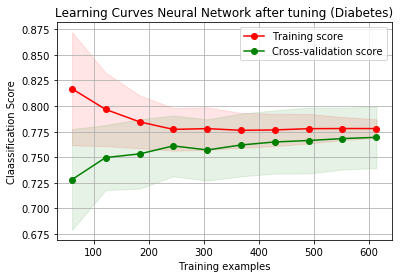

In [119]:
'''nn_clf2_OLD = MLPClassifier(hidden_layer_sizes=(100,), activation='identity', solver='lbfgs', alpha=0.475, 
                        batch_size='auto', learning_rate='constant', learning_rate_init=0.03, power_t=0.5, 
                        max_iter=200, shuffle=True, random_state=20, tol=0.0001, verbose=False, warm_start=False, 
                        momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)'''

nn_clf2 = MLPClassifier(hidden_layer_sizes=(100,100,100), activation='identity', solver='lbfgs', alpha=0.5, 
                        batch_size='auto', learning_rate='constant', learning_rate_init=0.03, power_t=0.5, 
                        max_iter=400, shuffle=True, random_state=20, tol=0.0001, verbose=False, warm_start=False, 
                        momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)

# Train Decision Tree Classifer
t0 = time.time()
nn_clf2 = nn_clf2.fit(diaX_train,diay_train)
t1 = time.time()
train_time[1] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = nn_clf2.predict(diaX_test)
t1 = time.time()
test_time[1] = t1 - t0

# Model Accuracy, how often is the classifier correct?
class_accuracy[1] = accuracy_score(diay_test, diay_pred)

print("Model Evaluation Metrics Neural Networks after tuning (Diabetes)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(train_time[1]))
print("Model Prediction Time (s): "+"{:.5f}".format(test_time[1]))
print("Accuracy:  "+"{:.2f}".format(class_accuracy[1]))


#learning curve plot
title = "Learning Curves Neural Network after tuning (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(nn_clf2, title, diaX, diaY, ylim=None, cv=cv, n_jobs=4)

## Learning Curve for Epochs

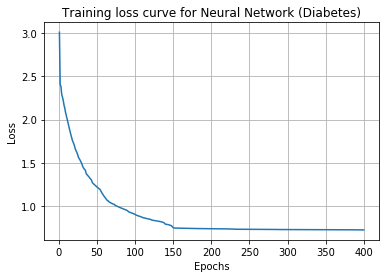

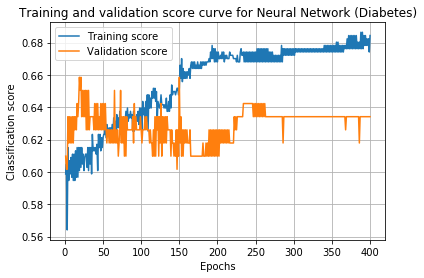

In [126]:
nn_clf = MLPClassifier(hidden_layer_sizes=(100,100,100), activation='identity', solver='lbfgs', alpha=0.5, 
                        batch_size='auto', learning_rate='constant', learning_rate_init=0.03, power_t=0.5, 
                        max_iter=1, shuffle=True, random_state=20, tol=0.0001, verbose=False, warm_start=True, 
                        momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, 
                        beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10)
epochs = 400
train_loss = np.empty(epochs)
train_scores = np.empty(epochs)
val_scores = np.empty(epochs)
# Split training set into training and validation
X_train1, X_val, y_train1, y_val = train_test_split(np.array(diaX_train),np.array(diay_train), test_size=0.20)
for i in range(epochs):
    nn_clf.fit(X_train1, y_train1)
    train_loss[i] = nn_clf.loss_
    train_scores[i] = accuracy_score(y_train1, nn_clf.predict(X_train1))
    val_scores[i] = accuracy_score(y_val, nn_clf.predict(X_val))

xrange = np.arange(epochs) + 1
plt.figure()
plt.plot(xrange, train_loss)
plt.title('Training loss curve for Neural Network (Diabetes)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.figure()
plt.plot(xrange, train_scores, label='Training score')
plt.plot(xrange, val_scores, label='Validation score')
plt.title('Training and validation score curve for Neural Network (Diabetes)')
plt.xlabel('Epochs')
plt.ylabel('Classification score')
plt.grid()
plt.legend(loc="best")
plt.show()

# Boosting

Model Evaluation Metrics Using GradientBoosting before tuning (Diabetets)
**************************************************************************
Model Training Time (s):   0.06084
Model Prediction Time (s): 0.33222
Accuracy:  0.72


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

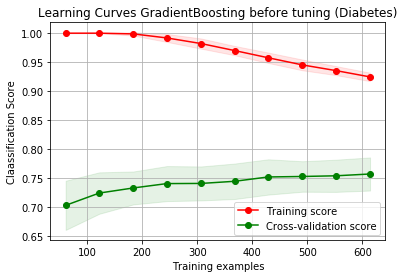

In [37]:
gb_clf1 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, 
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                     min_impurity_split=None, init=None, random_state=10, max_features=None, 
                                     verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)

# Train Decision Tree Classifer
t0 = time.time()
gb_clf1 = gb_clf1.fit(diaX_train,diay_train)
t1 = time.time()
prev_train_time[2] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = gb_clf1.predict(diaX_test)
t1 = time.time()
prev_test_time[2] = t1 - t0

# Model Accuracy, how often is the classifier correct?
prev_class_accuracy[2] = accuracy_score(diay_test, diay_pred)

print("Model Evaluation Metrics Using GradientBoosting before tuning (Diabetets)")
print("**************************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(prev_train_time[2]))
print("Model Prediction Time (s): "+"{:.5f}".format(prev_test_time[2]))
print("Accuracy:  "+"{:.2f}".format(prev_class_accuracy[2]))

#learning curve plot
title = "Learning Curves GradientBoosting before tuning (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(gb_clf1, title, diaX, diaY, ylim=None, cv=cv, n_jobs=4)

## Validation Curve

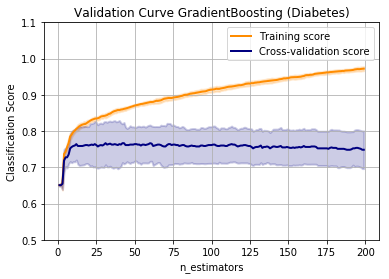

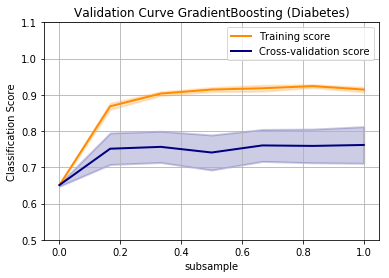

In [95]:
#plot validation curve
estimator = gb_clf1
#parameter_range1 = np.logspace(-3, 3, 7)
#parameter_range1 = np.linspace(0.0001, 0.01, 7)
parameter_range1 = np.arange(1,200)
#parameter_range1 = np.arange(1,1000, 20)
param_name1 = "n_estimators"

#parameter_range2 = np.logspace(-5, 1, 6)
parameter_range2 = np.linspace(0.001, 1, 7)
#parameter_range4 = np.arange(1, 25)
#parameter_range2 = np.arange(1, 50)
param_name2 = "subsample"


plot_validation_curve(estimator, diaX, diaY, param_name1, parameter_range1, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve GradientBoosting (Diabetes)", xlabel=param_name1, ylim= (0.5, 1.1))

plot_validation_curve(estimator, diaX, diaY, param_name2, parameter_range2, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve GradientBoosting (Diabetes)", xlabel=param_name2, ylim= (0.5, 1.1))


## Best Param Search

In [102]:
# use a full grid over all parameters
param_tuned = {'n_estimators': np.arange(1,10),
               'subsample': np.linspace(0.1,0.2,7),
              'max_depth': np.arange(1,8),
              'min_samples_leaf': np.arange(1,10),
               'max_leaf_nodes': [15, 5, 10, None],
               }

# run grid search
grid_search = GridSearchCV(gb_clf1, param_grid=param_tuned, iid= "False", cv=5, n_jobs = 4)
grid_search.fit(diaX_train,diay_train)
print("Best parameters for development set:")
print(grid_search.best_params_)

Best parameters for development set:
{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_leaf': 2, 'n_estimators': 9, 'subsample': 0.18333333333333335}


## After Tuning

Model Evaluation Metrics GradientBoosting after tuning (Diabetets)
**********************************************************************
Model Training Time (s):   0.00598
Model Prediction Time (s): 0.00000
Accuracy:  0.74


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

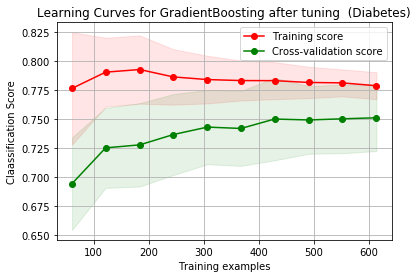

In [96]:
'''gb_clf3= GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=8, subsample=0.105, 
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=4, 
                                     min_weight_fraction_leaf=0.0, max_depth=1, min_impurity_decrease=0.0, 
                                     min_impurity_split=None, init=None, random_state=10, max_features=None, 
                                     verbose=0, max_leaf_nodes=5, warm_start=False, presort='auto', 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)'''

gb_clf2 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=9, subsample=0.18, 
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=2, 
                                     min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                     min_impurity_split=None, init=None, random_state=10, max_features=None, 
                                     verbose=0, max_leaf_nodes=5, warm_start=False, presort='auto', 
                                     validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)


# Train Decision Tree Classifer
t0 = time.time()
gb_clf2 = gb_clf2.fit(diaX_train,diay_train)
t1 = time.time()
train_time[2] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = gb_clf2.predict(diaX_test)
t1 = time.time()
test_time[2] = t1 - t0

# Model Accuracy, how often is the classifier correct?
class_accuracy[2] = accuracy_score(diay_test, diay_pred)
f1 = f1_score(diay_test, diay_pred)
precision = precision_score(diay_test, diay_pred)
recall = recall_score(diay_test, diay_pred)
cm = confusion_matrix(diay_test, diay_pred)


print("Model Evaluation Metrics GradientBoosting after tuning (Diabetets)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(train_time[2]))
print("Model Prediction Time (s): "+"{:.5f}".format(test_time[2]))
print("Accuracy:  "+"{:.2f}".format(class_accuracy[2]))

#learning curve plot
title = "Learning Curves for GradientBoosting after tuning  (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(gb_clf2, title, diaX, diaY, ylim=None, cv=cv, n_jobs=4)

# SVM


Model Evaluation Metrics SVM rbf kernel before tuning (Diabetets)
**********************************************************************
Model Training Time (s):   0.00999
Model Prediction Time (s): 0.00199
Accuracy:  0.75


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

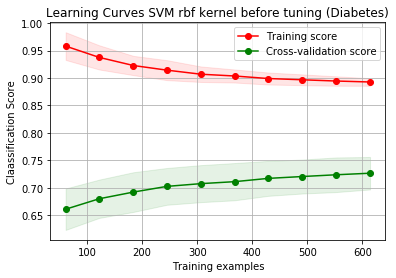

In [48]:
svm_clf1_rbf = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, 
               tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr',
               random_state=20)

# Train Decision Tree Classifer
t0 = time.time()
svm_clf1_rbf = svm_clf1_rbf.fit(diaX_train,diay_train)
t1 = time.time()
prev_train_time[3] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = svm_clf1_rbf.predict(diaX_test)
t1 = time.time()
prev_test_time[3] = t1 - t0

# Model Accuracy, how often is the classifier correct?
prev_class_accuracy[3] = accuracy_score(diay_test, diay_pred)


print("Model Evaluation Metrics SVM rbf kernel before tuning (Diabetets)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(prev_train_time[3]))
print("Model Prediction Time (s): "+"{:.5f}".format(prev_test_time[3]))
print("Accuracy:  "+"{:.2f}".format(prev_class_accuracy[3]))

#learning curve plot
title = "Learning Curves SVM rbf kernel before tuning (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(svm_clf1_rbf, title, diaX, diaY, ylim=None, cv=cv, n_jobs=10)

Model Evaluation Metrics SVM linear before tuning (Diabetets)
**********************************************************************
Model Training Time (s):   1.89695
Model Prediction Time (s): 0.00094
Accuracy:  0.77


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

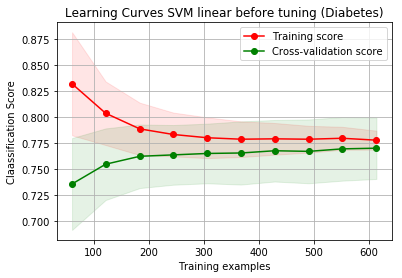

In [45]:
svm_clf1_lin = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, 
               tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr',
               random_state=20)

# Train Decision Tree Classifer
t0 = time.time()
svm_clf1_lin = svm_clf1_lin.fit(diaX_train,diay_train)
t1 = time.time()
prev_train_time[4] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = svm_clf1_lin.predict(diaX_test)
t1 = time.time()
prev_test_time[4] = t1 - t0

# Model Accuracy, how often is the classifier correct?
prev_class_accuracy[4] = accuracy_score(diay_test, diay_pred)

print("Model Evaluation Metrics SVM linear before tuning (Diabetets)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(prev_train_time[4]))
print("Model Prediction Time (s): "+"{:.5f}".format(prev_test_time[4]))
print("Accuracy:  "+"{:.2f}".format(prev_class_accuracy[4]))


#learning curve plot
title = "Learning Curves SVM linear before tuning (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(svm_clf1_lin, title, diaX, diaY, ylim=None, cv=cv, n_jobs=10)

## Validation Curve

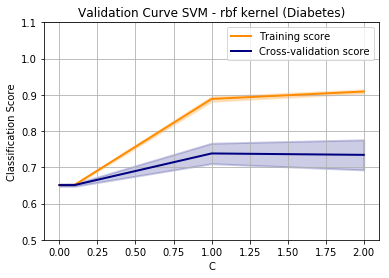

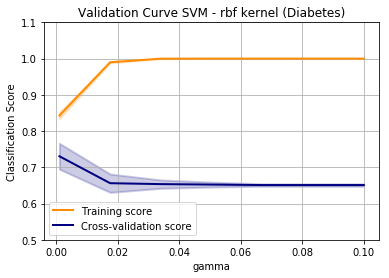

In [25]:
#plot validation curve
estimator1 = svm_clf1_rbf
estimator2 = svm_clf1_lin
#parameter_range1 = np.logspace(-3, 3, 7)
#parameter_range1 = np.linspace(0.0001, 0.01, 7)

parameter_range5 = [0.1,1,10,100,1000]
parameter_range1 = [0.0001,0.001,0.01,0.1,1,2]
param_name1 = "C"

#parameter_range2 = np.logspace(-5, 1, 6)
#parameter_range2 = np.linspace(0.001, 0.9, 7)
#parameter_range4 = np.arange(1, 25)
parameter_range2 = np.linspace(0.001, 0.1, 7)
param_name2 = "gamma"


plot_validation_curve(estimator1, diaX, diaY, param_name1, parameter_range1, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve SVM - rbf kernel (Diabetes)", xlabel=param_name1, ylim= (0.5, 1.1))

plot_validation_curve(estimator1, diaX, diaY, param_name2, parameter_range2, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve SVM - rbf kernel (Diabetes)", xlabel=param_name2, ylim= (0.5, 1.1))


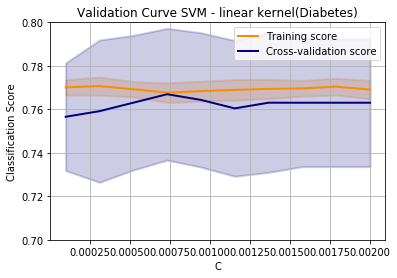

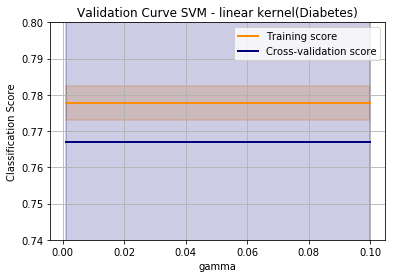

In [26]:
parameter_range1 = np.linspace(0.0001,0.002,10)
param_name1 = "C"

#parameter_range2 = np.logspace(-5, 1, 6)
#parameter_range2 = np.linspace(0.001, 0.9, 7)
#parameter_range4 = np.arange(1, 25)
parameter_range2 = np.linspace(0.001, 0.1, 7)
param_name2 = "gamma"

plot_validation_curve(estimator2, diaX, diaY, param_name1, parameter_range1, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve SVM - linear kernel(Diabetes)", xlabel=param_name1, ylim= (0.7, 0.8))

plot_validation_curve(estimator2, diaX, diaY, param_name2, parameter_range2, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve SVM - linear kernel(Diabetes)", xlabel=param_name2, ylim= (0.74, 0.8))

## Best Param Search

In [121]:
# use a full grid over all parameters
param_tuned1 = {'C':[0.001,0.1,1],
              'gamma': np.linspace(0.00001, 0.2, 7),
              'class_weight': [None, 'balanced'],
               'decision_function_shape': ['ovo','ovr']
               }

# run grid search
grid_search_rbf = GridSearchCV(svm_clf1_rbf, param_grid=param_tuned1, cv=5,  n_jobs = 4)
grid_search_rbf.fit(diaX_train,diay_train)
print("Best parameters for development set:")
print(grid_search_rbf.best_params_)

Best parameters for development set:
{'C': 1, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 1e-05}


In [122]:
# use a full grid over all parameters
param_tuned2 = {'C':[0.00075,0.0007],
              'gamma': np.linspace(0.00001, 0.2, 7),
              'class_weight': [None, 'balanced'],
               'decision_function_shape': ['ovo','ovr'],
               }

# run grid search
grid_search_lin = GridSearchCV(svm_clf1_lin, param_grid=param_tuned2, cv=5, iid=False, n_jobs = 4)
grid_search_lin.fit(diaX_train,diay_train)
print("Best parameters for development set:")
print(grid_search_lin.best_params_)

Best parameters for development set:
{'C': 0.00075, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 1e-05}


## After tuning

Model Evaluation Metrics SVM - rbf kernel after tuning (Diabetets)
**********************************************************************
Model Training Time (s):   0.00698
Model Prediction Time (s): 0.00100
Accuracy:  0.76


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

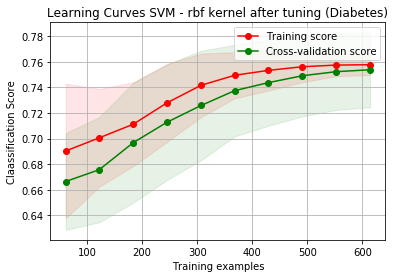

In [67]:
svm_clf2_rbf = SVC(C=1.0, kernel='rbf', degree=3, gamma=0.00001, coef0=0.0, shrinking=True, probability=False, 
               tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovo',
               random_state=20)

# Train Decision Tree Classifer
t0 = time.time()
svm_clf2_rbf = svm_clf2_rbf.fit(diaX_train,diay_train)
t1 = time.time()
train_time[3] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = svm_clf2_rbf.predict(diaX_test)
t1 = time.time()
test_time[3] = t1 - t0

# Model Accuracy, how often is the classifier correct?
class_accuracy[3] = accuracy_score(diay_test, diay_pred)

print("Model Evaluation Metrics SVM - rbf kernel after tuning (Diabetets)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(train_time[3]))
print("Model Prediction Time (s): "+"{:.5f}".format(test_time[3]))
print("Accuracy:  "+"{:.2f}".format(class_accuracy[3]))

#learning curve plot
title = "Learning Curves SVM - rbf kernel after tuning (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(svm_clf2_rbf, title, diaX, diaY, ylim=None, cv=cv, n_jobs=4)

Model Evaluation Metrics SVM - linear kernel after tuning (Diabetets)
**********************************************************************
Model Training Time (s):   0.01297
Model Prediction Time (s): 0.00000
Accuracy:  0.79


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

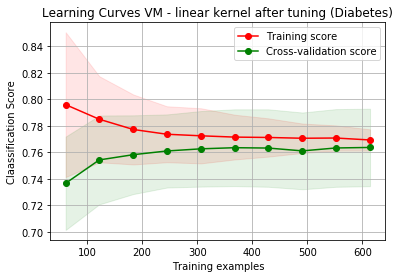

In [68]:
svm_clf2_lin = SVC(C=0.00075, kernel='linear', degree=3, gamma=0.00001, coef0=0.0, shrinking=True, probability=False, 
               tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr',
               random_state=20)

# Train Decision Tree Classifer
t0 = time.time()
svm_clf2_lin  = svm_clf2_lin.fit(diaX_train,diay_train)
t1 = time.time()
train_time[4] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = svm_clf2_lin.predict(diaX_test)
t1 = time.time()
test_time[4] = t1 - t0

# Model Accuracy, how often is the classifier correct?
class_accuracy[4] = accuracy_score(diay_test, diay_pred)

print("Model Evaluation Metrics SVM - linear kernel after tuning (Diabetets)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(train_time[4]))
print("Model Prediction Time (s): "+"{:.5f}".format(test_time[4]))
print("Accuracy:  "+"{:.2f}".format(class_accuracy[4]))

#learning curve plot
title = "Learning Curves VM - linear kernel after tuning (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(svm_clf2_lin, title, diaX, diaY, ylim=None, cv=cv, n_jobs=4)

# KNN

Model Evaluation Metrics KNeighbors before tuning (Diabetets)
**********************************************************************
Model Training Time (s):   0.00200
Model Prediction Time (s): 0.00199
Accuracy:  0.77


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

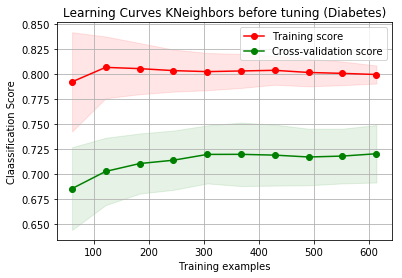

In [62]:
knn_clf1 = KNeighborsClassifier()

# Train Decision Tree Classifer
t0 = time.time()
knn_clf1 = knn_clf1.fit(diaX_train,diay_train)
t1 = time.time()
prev_train_time[5] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = knn_clf1.predict(diaX_test)
t1 = time.time()
prev_test_time[5] = t1 - t0

# Model Accuracy, how often is the classifier correct?
prev_class_accuracy[5] = accuracy_score(diay_test, diay_pred)

print("Model Evaluation Metrics KNeighbors before tuning (Diabetets)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(prev_train_time[5]))
print("Model Prediction Time (s): "+"{:.5f}".format(prev_test_time[5]))
print("Accuracy:  "+"{:.2f}".format(prev_class_accuracy[5]))

#learning curve plot
title = "Learning Curves KNeighbors before tuning (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(knn_clf1, title, diaX, diaY, ylim=None, cv=cv, n_jobs=4)

## Validation Curve

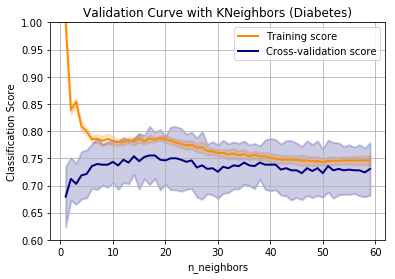

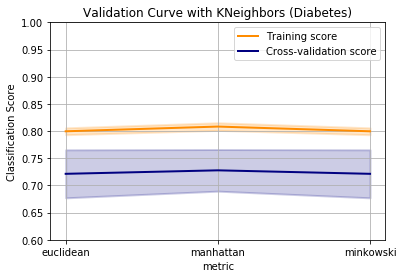

In [32]:
#plot validation curve
estimator = knn_clf1
#parameter_range1 = np.arange(1,1000, 20)
parameter_range1 = np.arange(1,60)
param_name1 = "n_neighbors"

#parameter_range2 = np.logspace(-5, 1, 6)
parameter_range2 =['euclidean','manhattan', 'minkowski']
#parameter_range2 = np.arange(1, 100, 15)
param_name2 = 'metric'


plot_validation_curve(estimator, diaX, diaY, param_name1, parameter_range1, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve with KNeighbors (Diabetes)", xlabel=param_name1, ylim= (0.6, 1))

plot_validation_curve(estimator, diaX, diaY, param_name2, parameter_range2, cv_value=10, scoring='accuracy', no_jobs=1,
                      title="Validation Curve with KNeighbors (Diabetes)", xlabel=param_name2, ylim= (0.6, 1))

## Best Param search

In [127]:
# use a full grid over all parameters
param_tuned = {'n_neighbors': np.arange(35,55),
              'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
               'leaf_size': [10,30,50],
               'metric': ['euclidean','manhattan', 'minkowski']
               }

# run grid search
grid_search = GridSearchCV(knn_clf1, param_grid=param_tuned, cv=5, n_jobs = 4)
grid_search.fit(diaX_train,diay_train)
print("Best parameters for development set:")
print(grid_search.best_params_)

Best parameters for development set:
{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'manhattan', 'n_neighbors': 49}


## After Tuning

Model Evaluation Metrics KNeighbors after tuning (Diabetets)
**********************************************************************
Model Training Time (s):   0.00100
Model Prediction Time (s): 0.00299
Accuracy:  0.77


<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

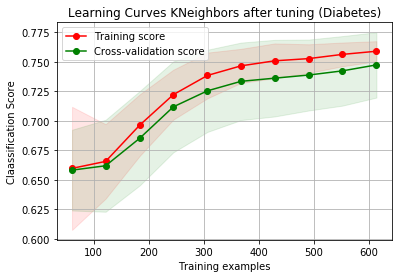

In [63]:
knn_clf2 = KNeighborsClassifier(n_neighbors=49, algorithm='ball_tree', leaf_size=10, metric= 'manhattan')

# Train Decision Tree Classifer
t0 = time.time()
knn_clf2 = knn_clf2.fit(diaX_train,diay_train)
t1 = time.time()
train_time[5] = t1 - t0

#Predict the response for test dataset
t0 = time.time()
diay_pred = knn_clf2.predict(diaX_test)
t1 = time.time()
test_time[5] = t1 - t0

# Model Accuracy, how often is the classifier correct?
class_accuracy[5] = accuracy_score(diay_test, diay_pred)

print("Model Evaluation Metrics KNeighbors after tuning (Diabetets)")
print("**********************************************************************")
print("Model Training Time (s):   "+"{:.5f}".format(train_time[5]))
print("Model Prediction Time (s): "+"{:.5f}".format(test_time[5]))
print("Accuracy:  "+"{:.2f}".format(class_accuracy[5]))

#learning curve plot
title = "Learning Curves KNeighbors after tuning (Diabetes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(knn_clf2, title, diaX, diaY, ylim=None, cv=cv, n_jobs=4)

# Comparing the classifiers

In [59]:
classifiers = ('Decision tree', 'Neural network', 'GradientBoost', 'SVM-rbf', 'SVM-linear','kNN')
y_label = np.arange(len(classifiers))

## Accuracy

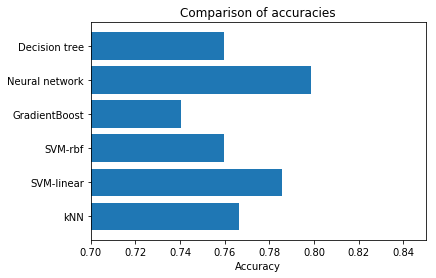

In [74]:
plt.figure()
plt.barh(y_label, class_accuracy)
plt.gca().set_yticks(y_label)
plt.gca().set_xlim(0.7, 0.85)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of accuracies')
plt.xlabel('Accuracy')
plt.show()

## Training time

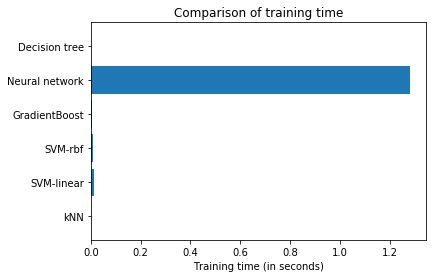

In [70]:
plt.figure()
plt.barh(y_label, train_time)
plt.gca().set_yticks(y_label)
#plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of training time')
plt.xlabel('Training time (in seconds)')
plt.show()

## Test time

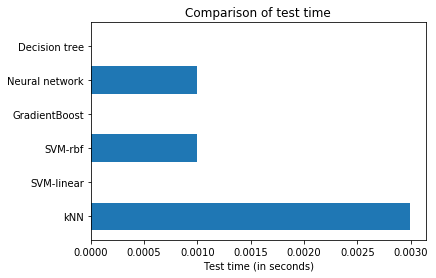

In [72]:
plt.figure()
plt.barh(y_label, test_time)
plt.gca().set_yticks(y_label)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of test time')
plt.xlabel('Test time (in seconds)')
plt.show()